In [2]:
import librosa
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import os

In [3]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return np.mean(mfccs, axis=1)

In [4]:
def load_data(data_dir):
    singer_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    features = []
    labels = []
    for i, singer in enumerate(singer_names):
        folder_path = os.path.join(data_dir, singer)
        
        if os.path.isdir(folder_path):
            print(f"Loading {singer} samples...")
            
            for audio_file in os.listdir(folder_path):
                if audio_file.endswith('.wav'):
                    file_path = os.path.join(folder_path, audio_file)
                    voice_features = extract_features(file_path)
                    features.append(voice_features)
                    labels.append(i)
    return np.array(features), np.array(labels), singer_names

In [5]:
data_dir = '/home/nirjhar/CODE/multiclass_voice_recog/dataset_5s'

In [6]:
# Load the voice data
print("Loading voice samples...")
X, y, singer_names = load_data(data_dir)

print(f"Total samples: {len(X)}")
print(f"Features per sample: {X.shape[1]}")

Loading voice samples...
Loading arijit samples...
Loading kishore samples...
Loading lata samples...


/usr/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1896
  warnings.warn(


Loading shreya samples...
Total samples: 277
Features per sample: 13


In [7]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 166
Testing samples: 111


In [8]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Create and train SVM classifier
model = svm.SVC(kernel='linear', decision_function_shape='ovr')
print("Training the SVM model...")
model.fit(X_train_scaled, y_train)

Training the SVM model...


SVC(kernel='linear')

In [10]:
# Test the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f} ({accuracy*100:.1f}%)")

Accuracy: 0.96 (96.4%)


In [11]:
# Show some predictions
print("\nSample predictions:")
for i in range(min(5, len(X_test))):
    actual = singer_names[y_test[i]]
    predicted = singer_names[y_pred[i]]
    print(f"Actual: {actual}, Predicted: {predicted}")


Sample predictions:
Actual: arijit, Predicted: arijit
Actual: kishore, Predicted: lata
Actual: shreya, Predicted: shreya
Actual: lata, Predicted: lata
Actual: shreya, Predicted: shreya


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

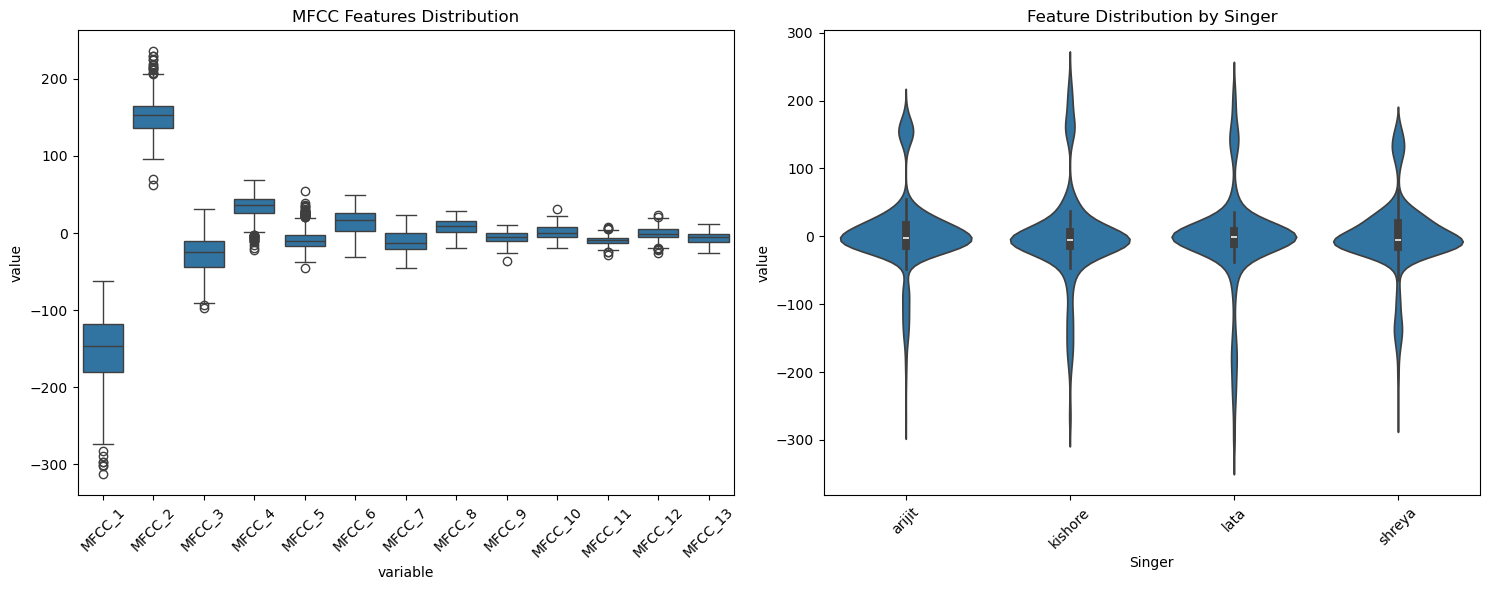

In [13]:
# Visualize MFCC feature distributions
plt.figure(figsize=(15, 6))
features_df = pd.DataFrame(X, columns=[f'MFCC_{i+1}' for i in range(X.shape[1])])
features_df['Singer'] = [singer_names[i] for i in y]

plt.subplot(1, 2, 1)
sns.boxplot(data=features_df.melt(id_vars=['Singer']), x='variable', y='value')
plt.xticks(rotation=45)
plt.title('MFCC Features Distribution')

plt.subplot(1, 2, 2)
sns.violinplot(data=features_df.melt(id_vars=['Singer']), x='Singer', y='value')
plt.xticks(rotation=45)
plt.title('Feature Distribution by Singer')
plt.tight_layout()
plt.show()

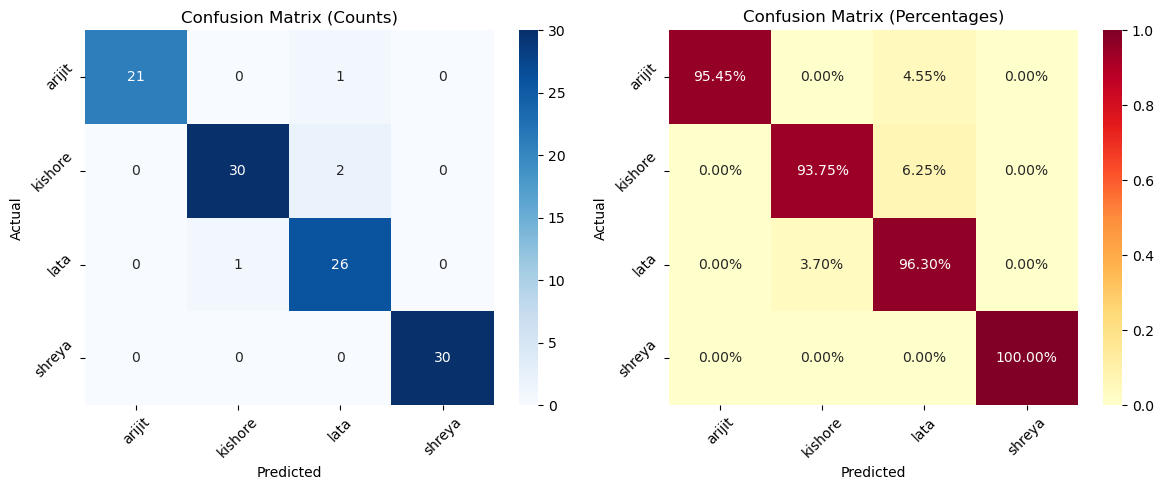

In [14]:
# Enhanced confusion matrix visualization
def plot_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 5))
    
    # Absolute numbers
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=singer_names,
                yticklabels=singer_names)
    plt.title('Confusion Matrix (Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # Percentages
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=singer_names,
                yticklabels=singer_names)
    plt.title('Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision, recall, and F1-score for each class (using 'macro' averaging)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Or, get a comprehensive report:
report = classification_report(y_test, y_pred)
print(report)

Precision: 0.9660734149054505
Recall: 0.9637521043771043
F1-Score: 0.9644241417497231
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.97      0.94      0.95        32
           2       0.90      0.96      0.93        27
           3       1.00      1.00      1.00        30

    accuracy                           0.96       111
   macro avg       0.97      0.96      0.96       111
weighted avg       0.97      0.96      0.96       111

